# Install

In [1]:
!pip install shap --quiet
!pip install pycaret --quiet
!pip install catboost --quiet
!pip install adjustText --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 532.9/532.9 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 484.7/484.7 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 62.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.4/73.4 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 68.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 159.4/159.4 kB 17.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.8/106.8 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 12.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 21.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 1.1 MB/s 

# Import

In [2]:
import warnings
from datetime import datetime
from tqdm import tqdm
import numpy as np
import pandas as pd
from pycaret.datasets import get_data
from category_encoders import CatBoostEncoder
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import FunctionTransformer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer, MissingIndicator
from sklearn.model_selection import train_test_split
from sklearn.metrics import average_precision_score, roc_auc_score
from sklearn.linear_model import LinearRegression
from lightgbm import LGBMClassifier, LGBMRegressor
from catboost import CatBoostClassifier
from scipy.stats import binom, norm
from shap import TreeExplainer
import matplotlib.pyplot as plt
from adjustText import adjust_text

In [3]:
warnings.filterwarnings("ignore")

# Constants

In [4]:
DATASET_NAMES = [
  "bank",
  "cancer",
  "credit",
  "diabetes",
  "electrical_grid",
  "employee",
  "heart",
  "heart_disease",
  "juice",
  "nba",
  "wine",
  "telescope",
  "us_presidential_election_results"]

In [5]:
COLORS = [
  "blue",
  "red",
  "forestgreen",
  "purple",
  "black",
  "orange",
  "gold",
  "cyan",
  "lime",
  "darkgray",
  "khaki",
  "olive",
  "magenta"
]

# Utils

In [6]:
def shap_sum2proba(shap_sum):
  """Compute sigmoid function of the Shap sum to get predicted probability."""

  return 1 / (1 + np.exp(-shap_sum))

def get_dataset(dataset_name):
  """Get dataset."""
  target_name = datasets.loc[datasets["Dataset"]==dataset_name, "Target Variable 1"]
  df = get_data(dataset_name, verbose=False)
  X, y = df.drop(target_name, axis=1), df[target_name]
  y = y.replace({yval: binval for yval, binval in zip(y.value_counts().index, [0,1])})
  num_features = X.columns[X.apply(is_numeric)].tolist()
  cat_features = [c for c in X.columns if c not in num_features]
  X[cat_features] = CatBoostEncoder().fit_transform(X[cat_features].fillna("NULL"), y)
  return X, y, num_features, cat_features

def is_numeric(x):
  """Check whether an object is numeric."""
  try:
    x+0
    return True
  except:
    return False

def get_preds_shaps(X, y, ix_trn, ix_val):
  """Get predictions (predicted probabilities) and SHAP values for a dataset.
  To speed up calculations, only Shap values regarding the validation set are computed."""

  model = LGBMClassifier(verbose=-1).fit(X.loc[ix_trn, :], y.loc[ix_trn])
  preds = pd.Series(model.predict_proba(X)[:,1], index=X.index)
  shap_explainer = TreeExplainer(model)
  shap_expected_value = shap_explainer.expected_value[-1]
  shaps = pd.DataFrame(
    data=shap_explainer.shap_values(X.loc[ix_val, :])[1],
    index=ix_val,
    columns=X.columns)
  return preds, shaps, shap_expected_value

# Get data

In [7]:
datasets = get_data()

,Dataset,Data Types,Default Task,Target Variable 1,Target Variable 2,# Instances,# Attributes,Missing Values
0,anomaly,Multivariate,Anomaly Detection,None,None,1000,10,N
1,france,Multivariate,Association Rule Mining,InvoiceNo,Description,8557,8,N
2,germany,Multivariate,Association Rule Mining,InvoiceNo,Description,9495,8,N
3,bank,Multivariate,Classification (Binary),deposit,None,45211,17,N
4,blood,Multivariate,Classification (Binary),Class,None,748,5,N
5,cancer,Multivariate,Classification (Binary),Class,None,683,10,N
6,credit,Multivariate,Classification (Binary),default,None,24000,24,N
7,diabetes,Multivariate,Classification (Binary),Class variable,None,768,9,N
8,electrical_grid,Multivariate,Classification (Binary),stabf,None,10000,14,N
9,employee,Multivariate,Classification (Binary),left,None,14999,10,N


# Intuition behind approximate-predictions

In [27]:
from pycaret.datasets import get_data
from sklearn.model_selection import train_test_split

df = get_data("concrete", verbose=False)
X, y = df.drop("strength", axis=1), df["strength"]
X_train, X_valid, y_train , y_valid = train_test_split(X, y)

In [9]:
from lightgbm import LGBMClassifier, LGBMRegressor

model = LGBMRegressor(verbose=-1).fit(X_train, y_train)
pred_valid = model.predict(X_valid)

In [10]:
from shap import TreeExplainer

shap_explainer = TreeExplainer(model)
shap_expected_value = shap_explainer.expected_value[-1]
shap_valid = shap_explainer.shap_values(X_valid)

In [11]:
pd.DataFrame(shap_valid, index=X_valid.index, columns=X_valid.columns)

,Cement (component 1)(kg in a m^3 mixture),Blast Furnace Slag (component 2)(kg in a m^3 mixture),Fly Ash (component 3)(kg in a m^3 mixture),Water (component 4)(kg in a m^3 mixture),Superplasticizer (component 5)(kg in a m^3 mixture),Coarse Aggregate (component 6)(kg in a m^3 mixture),Fine Aggregate (component 7)(kg in a m^3 mixture),Age (day)
280,-2.635840,-2.177151,0.171553,-0.768650,0.317591,0.420492,0.483185,-4.892627
148,14.469111,-4.026519,-0.223268,7.904137,1.713636,-0.839539,-1.949431,7.460482
693,-12.843056,-1.997725,-0.652329,-2.807039,-2.014414,0.781018,-2.463343,0.925550
716,-10.255890,2.382952,-0.381742,-1.394724,-3.906388,1.041369,-2.730328,-10.893018
601,4.456929,-3.879001,-0.206913,-3.583509,-2.864998,0.529074,-0.048730,2.567103
...,...,...,...,...,...,...,...,...
678,1.226298,5.519583,-0.236744,-1.818421,-4.765639,0.773006,-0.381669,2.477261
274,-3.206662,-1.740037,-0.048731,-0.029787,-0.117978,0.157501,0.336414,-16.741092
195,-4.956436,-2.546444,0.217060,1.405030,0.732818,-0.369520,-2.036861,-5.405626
96,12.571821,0.752401,0.063063,6.558229,3.608064,0.438212,-0.501021,-8.425200


In [12]:
approx_pred_valid = shap_expected_value + shap_valid.sum(axis=1)

In [13]:
assert (np.abs(approx_pred_valid - pred_valid) < 1e-10).all()

# Experiment

In [14]:
results = pd.DataFrame(columns=["dataset", "feature_set", "len_set", "preds_corr_bs", "ap_from_shaps_bs", "ap_from_model_bs", "roc_from_shaps_bs", "roc_from_model_bs"])

for dataset_name in tqdm(DATASET_NAMES):

  X, y, num_features, cat_features = get_dataset(dataset_name)

  results.loc[dataset_name + "_00", :] = dataset_name, sorted(X.columns), len(X.columns), [], [], [], [], []

  feature_sets = []

  for enum in range(50):
    row_id = dataset_name + "_" + str(enum+1).zfill(2)
    while True:
      feature_set = sorted(np.random.choice(X.columns, replace=False, size=np.random.randint(1,len(X.columns))))
      if feature_set not in feature_sets:
        feature_sets.append(feature_set)
        results.loc[row_id, :] = dataset_name, feature_set, len(feature_set), [], [], [], [], []
        break

  for bootstrap_iter in range(5):

    ix_trn, ix_val = train_test_split(X.index, test_size=.25)

    preds, shaps, shaps_ev = get_preds_shaps(X=X, y=y, ix_trn=ix_trn, ix_val=ix_val)

    # save results of the full model
    row_id = dataset_name + "_00"
    results.loc[row_id, "ap_from_shaps_bs"].append(average_precision_score(y.loc[ix_val], preds.loc[ix_val]))
    results.loc[row_id, "ap_from_model_bs"].append(average_precision_score(y.loc[ix_val], preds.loc[ix_val]))
    results.loc[row_id, "roc_from_shaps_bs"].append(roc_auc_score(y.loc[ix_val], preds.loc[ix_val]))
    results.loc[row_id, "roc_from_model_bs"].append(roc_auc_score(y.loc[ix_val], preds.loc[ix_val]))

    for enum, feature_set in enumerate(feature_sets):

      row_id = dataset_name + "_" + str(enum+1).zfill(2)

      # compute predictions as estimated from the SHAP values of the feature set
      preds_from_shaps = shap_sum2proba(shap_sum = shaps_ev + shaps.loc[ix_val, feature_set].sum(axis=1))

      # get predictions from model trained on the feature set
      preds_from_model = pd.Series(
        LGBMClassifier(verbose=-1) \
          .fit(X.loc[ix_trn, feature_set], y.loc[ix_trn]) \
          .predict_proba(X.loc[ix_val, feature_set])[:,1],
        index=ix_val)

      results.loc[row_id, "preds_corr_bs"].append(preds_from_shaps.corr(preds_from_model))
      results.loc[row_id, "ap_from_shaps_bs"].append(average_precision_score(y.loc[ix_val], preds_from_shaps))
      results.loc[row_id, "ap_from_model_bs"].append(average_precision_score(y.loc[ix_val], preds_from_model))
      results.loc[row_id, "roc_from_shaps_bs"].append(roc_auc_score(y.loc[ix_val], preds_from_shaps))
      results.loc[row_id, "roc_from_model_bs"].append(roc_auc_score(y.loc[ix_val], preds_from_model))

results["preds_corr"] = results["preds_corr_bs"].apply(lambda row: np.mean(row))
results["ap_from_shaps"] = results["ap_from_shaps_bs"].apply(lambda row: np.mean(row))
results["ap_from_model"] = results["ap_from_model_bs"].apply(lambda row: np.mean(row))
results["roc_from_shaps"] = results["roc_from_shaps_bs"].apply(lambda row: np.mean(row))
results["roc_from_model"] = results["roc_from_model_bs"].apply(lambda row: np.mean(row))

  8%|▊         | 1/13 [03:54<46:48, 234.06s/it]

 15%|█▌        | 2/13 [04:12<19:42, 107.48s/it]

 23%|██▎       | 3/13 [06:42<21:06, 126.62s/it]

 31%|███       | 4/13 [07:06<12:53, 86.00s/it] 

 46%|████▌     | 6/13 [09:36<09:21, 80.14s/it]

 54%|█████▍    | 7/13 [09:50<05:51, 58.66s/it]

 77%|███████▋  | 10/13 [11:05<01:52, 37.51s/it]

 85%|████████▍ | 11/13 [11:58<01:24, 42.03s/it]

100%|██████████| 13/13 [14:01<00:00, 64.75s/it]


# Checkpoint

In [15]:
results.to_csv("drive/MyDrive/Datasets/tds/shap4feature_selection/results.csv", sep="\t")

In [16]:
results = pd.read_csv("drive/MyDrive/Datasets/tds/shap4feature_selection/results.csv", sep="\t", index_col=0)

# Analysis

## Examples from Heart dataset

In [17]:
X, y, num_features, cat_features = get_dataset("heart")

In [18]:
X.shape

(200, 15)

In [19]:
for col in X.columns:
    print(col)

AGE_50
MD_50
SBP_50
DBP_50
HT_50
WT_50
CHOL_50
SES
CL_STATUS
MD_62
SBP_62
DBP_62
CHOL_62
WT_62
IHD_DX


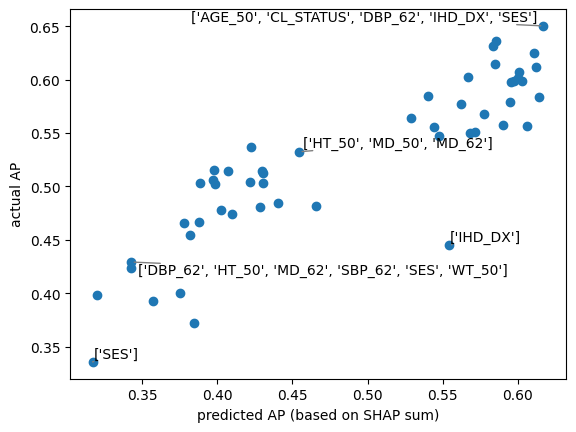

In [20]:
fig, ax = plt.subplots()

results_dataset = results[results["dataset"]=="heart"]

ax.scatter(x=results_dataset["ap_from_shaps"], y=results_dataset["ap_from_model"])
ax.set_xlabel("predicted AP (based on SHAP sum)")
ax.set_ylabel("actual AP")

texts = [ax.text(x=results_dataset.loc[i,"ap_from_shaps"],y=results_dataset.loc[i,"ap_from_model"],s=results_dataset.loc[i,"feature_set"]) for i in ['heart_06', 'heart_08', 'heart_19', 'heart_23', 'heart_32']]
adjust_text(texts, arrowprops=dict(arrowstyle="-", color="grey"))

fig.savefig("heart_1.png", dpi=200, bbox_inches="tight");

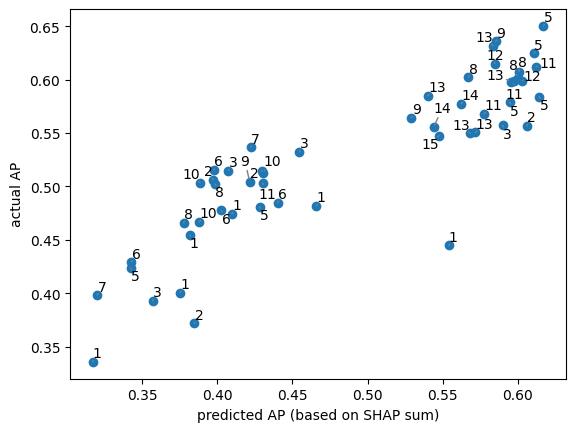

In [21]:
fig, ax = plt.subplots()

results_dataset = results[results["dataset"]=="heart"]

ax.scatter(x=results_dataset["ap_from_shaps"], y=results_dataset["ap_from_model"])
ax.set_xlabel("predicted AP (based on SHAP sum)")
ax.set_ylabel("actual AP")

texts = [ax.text(x=results_dataset.loc[i,"ap_from_shaps"],y=results_dataset.loc[i,"ap_from_model"],s=results_dataset.loc[i,"len_set"]) for i in results_dataset.index]
adjust_text(texts, arrowprops=dict(arrowstyle="-", color="grey"))

fig.savefig("heart_2.png", dpi=200, bbox_inches="tight");

## Visualizing all the datasets together

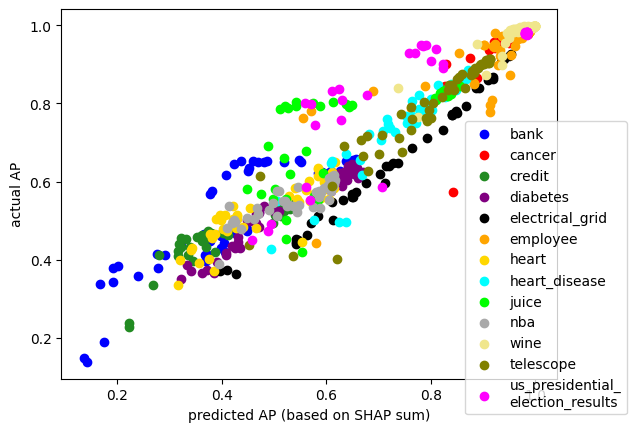

In [22]:
fig, ax = plt.subplots()

for dataset, color in zip(DATASET_NAMES, COLORS):
  results_dataset = results[results["dataset"]==dataset]
  ax.scatter(
    x=results_dataset["ap_from_shaps"],
    y=results_dataset["ap_from_model"],
    color=color,
    label=dataset if dataset != "us_presidential_election_results" else "us_presidential_\nelection_results")

ax.set_xlabel("predicted AP (based on SHAP sum)")
ax.set_ylabel("actual AP")
ax.legend(loc='center left', bbox_to_anchor=(0.8, 0.3))

fig.savefig("all_datasets.png", dpi=200, bbox_inches="tight");

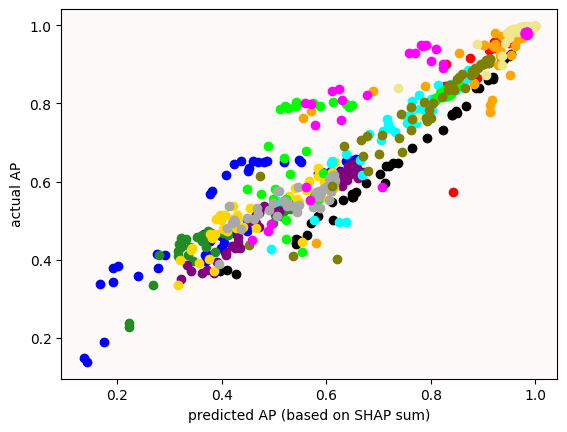

In [23]:
fig, ax = plt.subplots()

for dataset, color in zip(DATASET_NAMES, COLORS):
  results_dataset = results[results["dataset"]==dataset]
  ax.scatter(
    x=results_dataset["ap_from_shaps"],
    y=results_dataset["ap_from_model"],
    color=color,
    label=dataset if dataset != "us_presidential_election_results" else "us_presidential_\nelection_results")

ax.set_facecolor("snow")
ax.set_xlabel("predicted AP (based on SHAP sum)")
ax.set_ylabel("actual AP")

fig.savefig("all_datasets_wo_legend.png", dpi=200, bbox_inches="tight");

In [24]:
results.groupby("dataset").apply(lambda d: d["ap_from_shaps"].corr(d["ap_from_model"], method="spearman")).apply(lambda x: str(int(round(x*100,0)))+"%")

dataset
bank                                 91%
cancer                               94%
credit                               96%
diabetes                             96%
electrical_grid                     100%
employee                             93%
heart                                89%
heart_disease                        98%
juice                                88%
nba                                  89%
telescope                            98%
us_presidential_election_results     87%
wine                                 94%
dtype: object